**классификатор изображений (HOG)**

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
import numpy as np
import numpy.random as rng
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

Navneet Dalal and Bill Triggs  
Histograms of Oriented Gradients for Human Detection.     
http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf


Satya Mallick  
Histogram of Oriented Gradients explained using OpenCV.      
https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8

## подготовка данных

In [2]:
from sklearn.datasets import fetch_openml  # https://www.openml.org

X,target = fetch_openml( name='Fashion-MNIST', as_frame=False, return_X_y=True)
X = X.astype(np.float32).reshape(70000,28,28)
target = target.astype(np.uint8)

from sklearn.model_selection import train_test_split
image_train, image_test, target_train, target_test = train_test_split(X, target, test_size=.2)
display( image_train.shape, image_test.shape )

(56000, 28, 28)

(14000, 28, 28)

In [3]:
# from tensorflow.keras.datasets import fashion_mnist

# (image_train, target_train),(image_test, target_test) =\
#                     fashion_mnist.load_data()

# image_train.shape, image_test.shape

Гистограмма направленных градиентов (Histogram of Oriented Gradients, HOG)

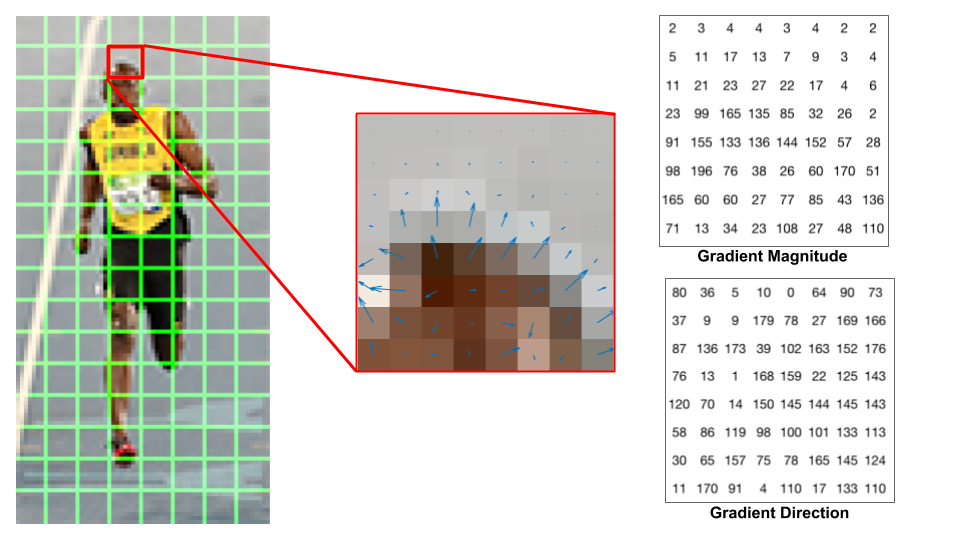

In [4]:
# !pip3 install scikit-image

In [5]:
from skimage.feature import hog

In [6]:
# параметры HOG:  pixels per cell, cells per block

# приувеличении детализации увеличивается точность 
# при этом растёт размер датасета и требования к производительности 

ppc, cpb = (8,8), (2,2) 
# ppc, cpb = (2,2), (4,4)

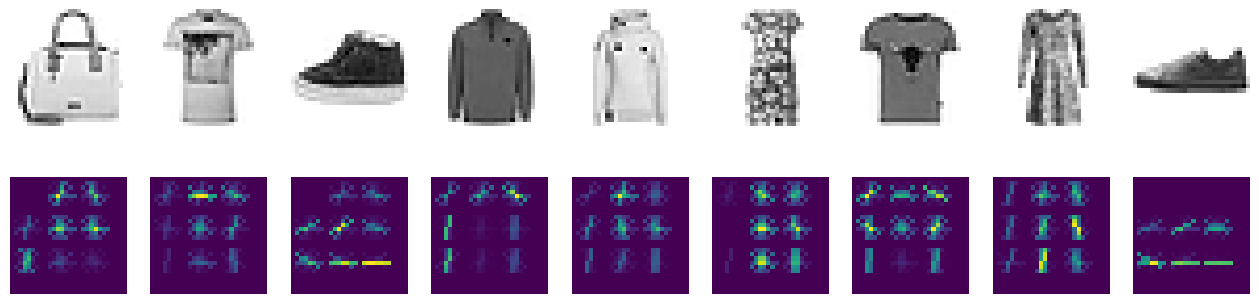

In [7]:
n_show = 9 # количество примеров 

plt.figure(figsize=(16,4))
for n,i in enumerate(rng.permutation(len(image_train))[:n_show], start=1):
    img = image_train[i]
    
    plt.subplot(2,n_show,n)
    plt.axis(False)
    plt.imshow(img,cmap='gray_r')

    _,hog_img = hog(img,pixels_per_cell=ppc,cells_per_block=cpb,visualize=True,)
    plt.subplot( 2, n_show, n+n_show)
    plt.axis(False)
    plt.imshow(hog_img) #,cmap='gray_r')

In [8]:
%%time

X_train = np.array([ 
    hog(x, pixels_per_cell=ppc, cells_per_block=cpb) 
    for x in tqdm(image_train) ])

X_test  = np.array([ 
    hog(x, pixels_per_cell=ppc, cells_per_block=cpb) 
    for x in tqdm(image_test)  ])

X_train.shape, X_test.shape

  0%|          | 0/56000 [00:00<?, ?it/s]

  0%|          | 0/14000 [00:00<?, ?it/s]

CPU times: user 10.3 s, sys: 34.7 ms, total: 10.4 s
Wall time: 10.4 s


((56000, 144), (14000, 144))

In [9]:
# 28*28 = 784

## обучение модели

In [10]:
from sklearn.model_selection import train_test_split

# уменьшаем размер учебного набора для SVM
X_train_, _, target_train_, _ = train_test_split( 
    X_train, target_train, test_size=.73)

display( X_train_.shape)

(15120, 144)

In [11]:
%%time

from sklearn import svm

model = svm.SVC().fit( X_train_, target_train_ )

CPU times: user 3.77 s, sys: 3.82 ms, total: 3.78 s
Wall time: 3.78 s


## оценка результатов

In [12]:
display( X_test.shape )

(14000, 144)

In [13]:
%%time 

o_test = model.predict(X_test)

CPU times: user 12.9 s, sys: 4.05 ms, total: 12.9 s
Wall time: 13 s


In [14]:
class_names = [ 
    'футболка', 
    'брюки', 
    'свитер', 
    'платье', 
    'пальто', 
    'сандали', 
    'рубашка', 
    'тапки', 
    'сумка', 
    'полусапожки', 
    ]

In [15]:
from sklearn.metrics import classification_report

print(classification_report(target_test, o_test, target_names=class_names) ) 

              precision    recall  f1-score   support

    футболка       0.77      0.82      0.80      1393
       брюки       0.97      0.94      0.96      1427
      свитер       0.76      0.72      0.74      1428
      платье       0.84      0.85      0.84      1431
      пальто       0.70      0.77      0.73      1399
     сандали       0.94      0.93      0.93      1366
     рубашка       0.58      0.53      0.55      1414
       тапки       0.91      0.92      0.92      1398
       сумка       0.96      0.96      0.96      1368
 полусапожки       0.95      0.95      0.95      1376

    accuracy                           0.84     14000
   macro avg       0.84      0.84      0.84     14000
weighted avg       0.84      0.84      0.84     14000



---

при увеличении детализации увеличивается точность    
при этом растёт размер датасета и требования к производительности 

для 
pixels per cell = (2,2) 
и cells per block = (4,4)

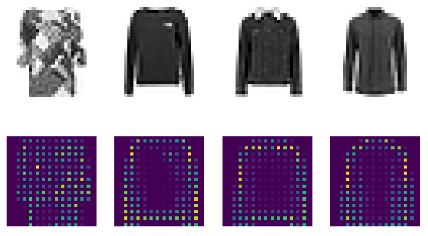


размер учебного датасета (16200, 17424)    
время обучения - 10min 28s   

размер тестового датасета (10000, 17424)   
время обработки теста - 21min 51s   

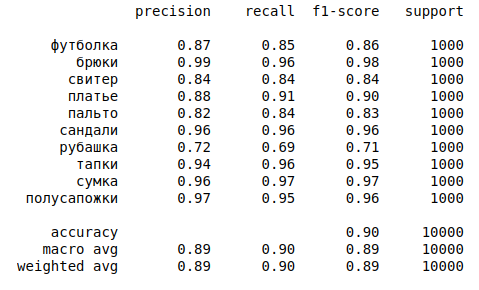


---

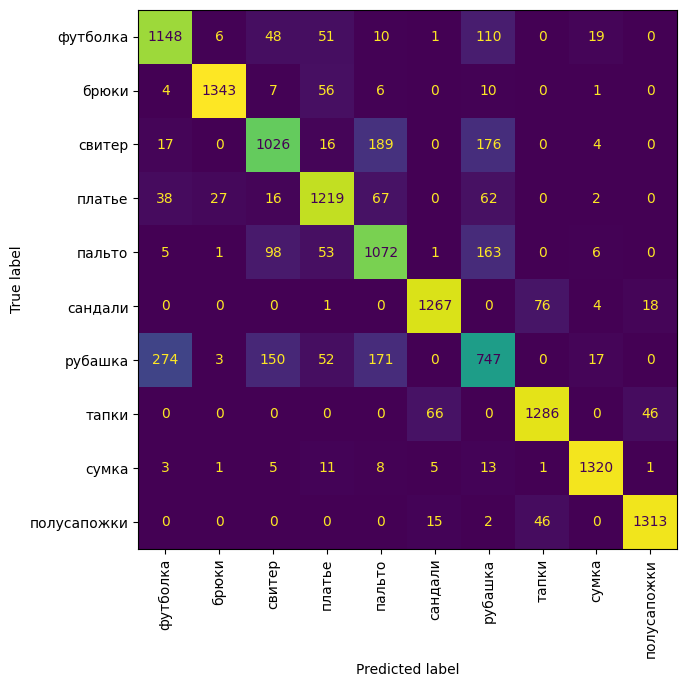

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize=(7,7))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(target_test,o_test), 
    display_labels=class_names,
)
disp.plot(ax=ax, xticks_rotation='vertical', include_values=True, cmap='viridis',  colorbar=False,)
plt.show()

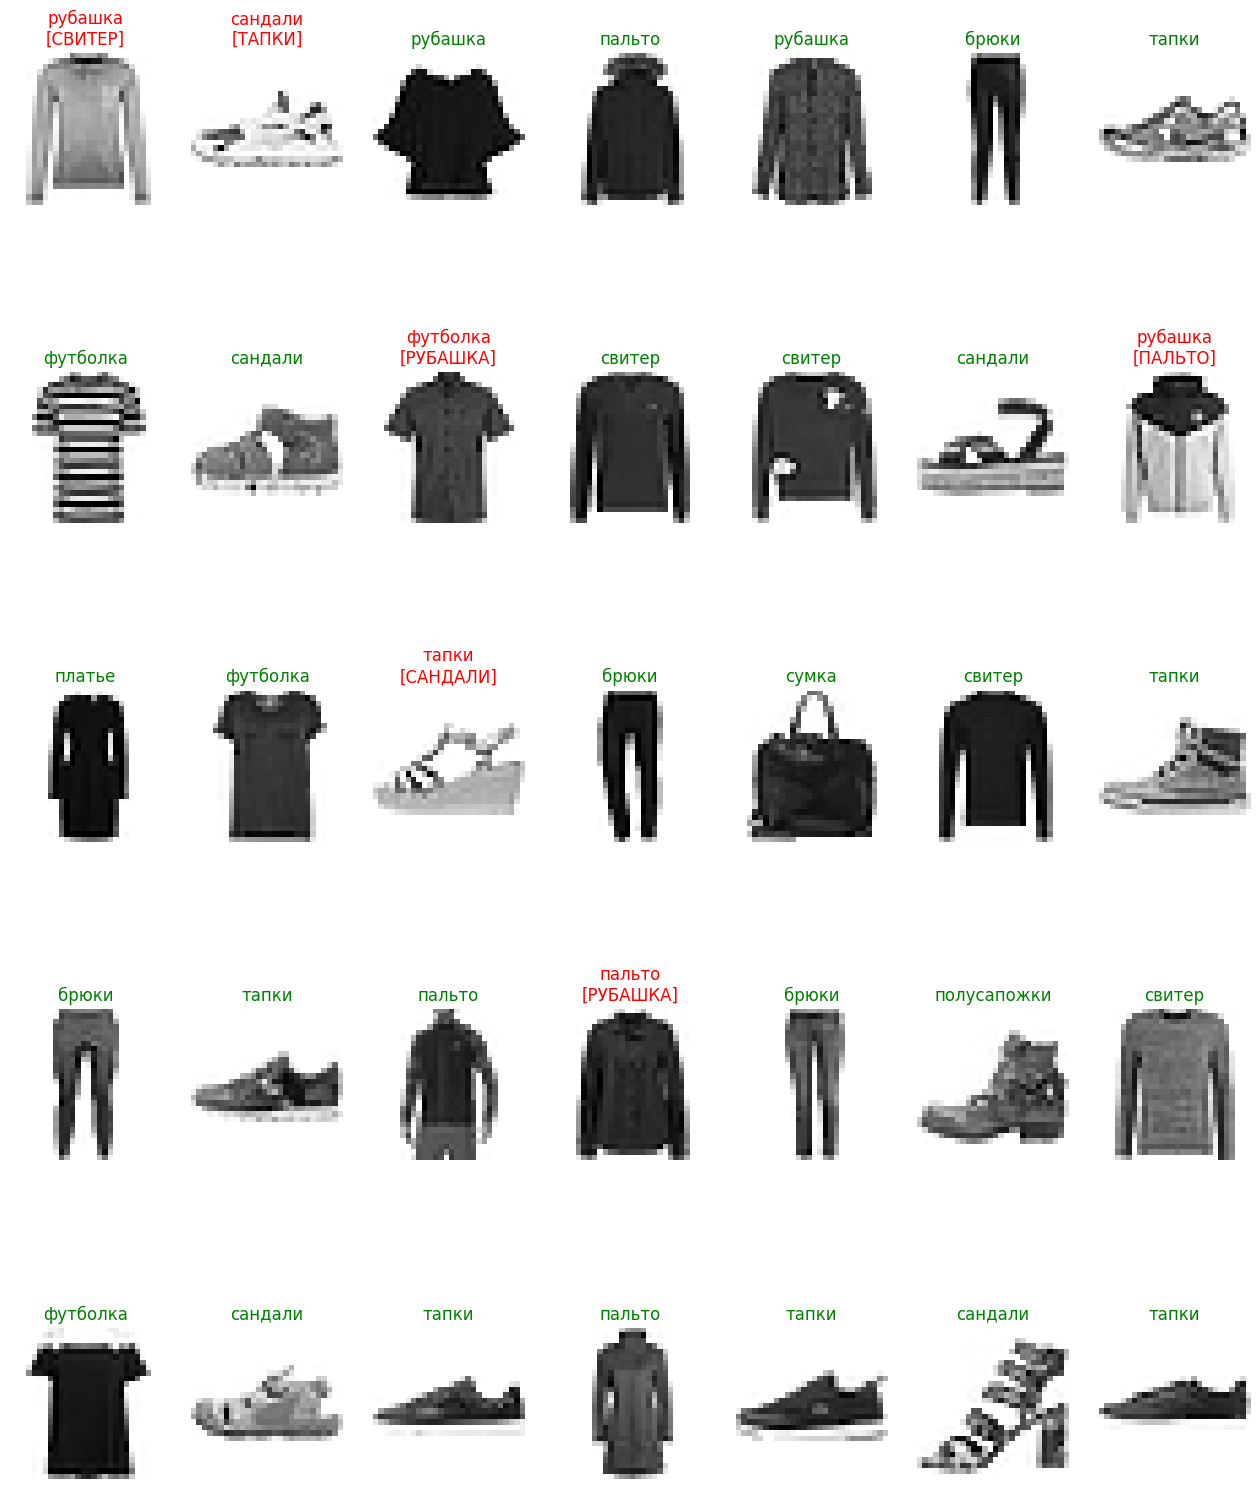

In [17]:
n_show, n_cols = 35, 7

n_rows = np.ceil(n_show/n_cols).astype(int)

plt.figure(figsize=(16,4*n_rows,))
for n,i in enumerate( rng.permutation(len(image_test))[:n_show] ):
    img = image_test[i]
    
    er = target_test[i]==o_test[i]
    t_mark = class_names[target_test[i]] 
    t_pred = class_names[o_test[i]] 
    t,c = (t_mark,'g') if er else (f'{t_pred}\n[{t_mark.upper()}]','r')
   
    plt.subplot(n_rows,n_cols,n+1)
    plt.axis(False)
    plt.title(t,color=c)
    plt.imshow(img,cmap='gray_r')
